# Merging

# Índice 
1. [Introduction](#introduction)
2. [Import Materials](#importmaterials)    
    2.1. [Import Libraries](#importlibraries)     
    2.2. [Import the dataset](#importdataset)
3. [Clusterings](#clustering)    


<hr>
<a class="anchor" id="introduction">
    
# 1. Introduction
    
</a>


This notebook analyzes customer data from ABCDEats Inc., a fictional food delivery service, over three months. The goal is to create clusters of customers and make different marketing startegies for each of them....    
**Project by** Dinis Pinto (20240612), Joana Rodrigues (20240603), João Marques (20240656), and Mara Simões (20240326) - **Group 27**.

<hr>
<a class="anchor" id="importmaterials">
    
# 2. Import Materials
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 2.1. Import Libraries
    
</a>

For this project, we'll install some helpful libraries to make analysis easier and add features like better plotting, data handling, and modeling tools. For example, `matplotlib` and `seaborn` allow us to create clear, customizable plots, while `pandas` and `numpy` make data processing smoother.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
#pip install umap-learn
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import umap


<hr>
<a class="anchor" id="importdataset">
    
## 2.2. Import Dataset
    
</a>

### Data in dataset
The different columns in the dataset give out the following information:   
- `customer_id` - Unique identifier for each customer.
- `customer_region` - Geographic region where the customer is located.
- `customer_age` - Age of the customer.
- `vendor_count` - Number of unique vendors the customer has ordered from.
- `product_count` - Total number of products the customer has ordered.
- `is_chain` - Indicates whether the customer’s order was from a chain restaurant.
- `first_order` - Number of days from the start of the dataset when the customer first placed an order.
- `last_order` - Number of days from the start of the dataset when the customer most recently placed an order.
- `last_promo` - The category of the promotion or discount most recently used by the customer.
- `payment_method` - Method most recently used by the customer to pay for their orders.
- `CUI_American`, `CUI_Asian`, `CUI_Chinese`, `CUI_Italian`... - The amount in monetary units spent by the customer from the indicated type of cuisine. 
- `DOW_0` to `DOW_6` - Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday).
- `HR_0` to `HR_23` - Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

In [2]:
df_behaviour = pickle.load(open("df_behaviour.pkl", 'rb'))
# df_time = pickle.load(open("df_time.pkl", 'rb'))
df_preferences = pickle.load(open("df_preferences.pkl", 'rb'))
# df_preferences_grouped = pickle.load(open("df_preferences_grouped.pkl", 'rb'))

df = pickle.load(open("df_final.pkl", 'rb'))

For the analysis we remove:
- all the DOW_ as the information is not varying a lot and is already present by being divided in days of the week and weekend.
- all the HR_ because the information doesn't vary a lot between them and would lead to a lot of information that can also be seen and analysed through the groups made of hours
- customer_age because as a numeric varible all clusters would have its mean (27.5) as its distribution is normal, so we put them into groups so we can better try to understand which cluster contains each age group, so we transformed age into a categorical column

In [3]:
df = df.loc[:, ~df.columns.str.startswith(('DOW_', 'HR_', 'customer_age', 'asian_cuisines', 'american_cuisines', 'cafe_desserts'))] 
not_used_columns = [col for col in df.columns if col not in df_preferences.columns and col not in df_behaviour.columns]
categorical_columns = ['customer_region', 'last_promo', 'payment_method', 'age_range', 'customer_city']
numeric_columns = [col for col in df if col not in categorical_columns]

## 3. Optimal clusters for each segmentation
From notebook part 2 and 3 we chose the best clustering approach for each of the segmentation after exploring several different ones.
## 3.1. df_behaviour - 2 clusters with K-Means

In [4]:
kmclust_behaviour = KMeans(n_clusters=2, init='k-means++', n_init=15, random_state=1)
km_labels_behaviour = kmclust_behaviour.fit_predict(df_behaviour)

df_concat = pd.concat((df_behaviour, pd.Series(km_labels_behaviour, name='labels', index=df_behaviour.index)), axis=1)
df_concat.groupby('labels').mean()

,monetary,product_count,days_as_customer,last_order,diversification
labels,,,,,
0,0.058902,0.037625,0.098987,0.542208,0.047570
1,0.116144,0.126914,0.631344,0.849344,0.164048


## 3.2. df_preferences - 6 clusters with K-Means
To avoid having to repeat code already done we imported the pickle with the clustering already done as SOM is more computationally expensive than K-Means.

In [5]:
kmclust_pref = KMeans(n_clusters=6, init='k-means++', n_init=15, random_state=1)
km_labels_pref = kmclust_pref.fit_predict(df_preferences)

df_concat = pd.concat((df_preferences, pd.Series(km_labels_pref, name='labels', index=df_preferences.index)), axis=1)
df_concat.groupby('labels').mean()

,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai
labels,,,,,,,,,,,,,,,
0,0.027220,0.012574,0.002934,0.010863,0.006683,0.003989,0.000925,0.007631,0.022374,0.026248,0.016042,0.001869,0.023475,0.000868,0.291378
1,0.019242,0.216614,0.018318,0.001361,0.000173,0.005966,0.013336,0.005275,0.001749,0.002579,0.010791,0.000134,0.001869,0.030377,0.000934
2,0.258304,0.025642,0.008532,0.006488,0.002406,0.005598,0.006293,0.004912,0.007485,0.018062,0.012314,0.000236,0.010067,0.012527,0.003572
3,0.022972,0.011801,0.004526,0.015366,0.014283,0.007693,0.001726,0.009540,0.015071,0.022955,0.013112,0.005753,0.225036,0.002005,0.007868
4,0.024158,0.027023,0.008180,0.006745,0.002830,0.006158,0.007889,0.008396,0.006365,0.012570,0.219399,0.001841,0.007351,0.015485,0.004828
5,0.016077,0.014785,0.016607,0.005759,0.015696,0.010026,0.009200,0.010125,0.012261,0.017726,0.006320,0.007677,0.010031,0.015625,0.003555


## 3.3. Merge
In this section we will merge the clusters of the two segmentations.   
The following table shows the 4*3 clusters formed from this.

In [6]:
# Applying the right clustering (algorithm and number of clusters) for each perspective

df['behavior_labels'] = km_labels_behaviour
df['preference_labels'] = km_labels_pref

crosstab_df = pd.crosstab(df['behavior_labels'],
            df['preference_labels'])
crosstab_df

preference_labels,0,1,2,3,4,5
behavior_labels,,,,,,
0,246,1295,847,638,862,11298
1,455,1926,1388,1137,1047,7387


### 3.3.1. Reformulation of clusters
From the previous code we can see that some of the clusters formed have some clusters with few points, this way our goal is to join this points as it doesnt make sense to be doing specific marketing strategies for a very neesh group of people.

In [7]:
#1. Determining the threshold from which the clusters are joined
threshold = len(df_behaviour) * 0.045  

# Identify clusters smaller than the threshold
to_merge = []
for behavior_label, row in crosstab_df.iterrows():
    for preference_label, count in row.items():
        if count is not None and count < threshold:  # Check for None values
            to_merge.append((behavior_label, preference_label))

# Output results
print("Threshold:", threshold)
print("Clusters to merge:", to_merge)


Threshold: 1283.6699999999998
Clusters to merge: [(0, 0), (0, 2), (0, 3), (0, 4), (1, 0), (1, 3), (1, 4)]


In [8]:
df_centroids = df.groupby(['behavior_labels', 'preference_labels'])\
    [numeric_columns].mean()
df_centroids

vendor_count  product_count   chained  \
behavior_labels preference_labels                                          
0               0                      0.074864       0.056697  0.057588   
                1                      0.077992       0.064621  0.041634   
                2                      0.063951       0.052787  0.061344   
                3                      0.076149       0.063686  0.059692   
                4                      0.069219       0.048510  0.051527   
                5                      0.049367       0.030676  0.048987   
1               0                      0.235531       0.149393  0.137637   
                1                      0.224732       0.149205  0.098607   
                2                      0.214998       0.149894  0.144182   
                3                      0.283568       0.184187  0.165494   
                4                      0.228271       0.143417  0.125915   
                5                      0.183679       0.104244  0.119557   

                                   first_order  last_order  CUI_American  \
behavior_labels preference_labels                                          
0               0                     0.402710    0.553342      0.012346   
                1                     0.445448    0.565405      0.007434   
                2                     0.421461    0.545481      0.226265   
                3                     0.427691    0.561076      0.007866   
                4                     0.460338    0.572738      0.012171   
                5                     0.445051    0.535667      0.012597   
1               0                     0.202759    0.856313      0.035262   
                1                     0.224126    0.854713      0.027182   
                2                     0.200352    0.854963      0.277855   
                3                     0.198202    0.863833      0.031449   
                4                     0.219251    0.854834      0.034027   
                5                     0.223526    0.843450      0.021398   

                                   CUI_Asian  CUI_Beverages  CUI_Cafe  \
behavior_labels preference_labels                                       
0               0                   0.005212       0.001255  0.000507   
                1                   0.180941       0.008714  0.000000   
                2                   0.011717       0.005120  0.003154   
                3                   0.003660       0.001415  0.004638   
                4                   0.015416       0.003655  0.002522   
                5                   0.013691       0.013350  0.004095   
1               0                   0.016555       0.003842  0.016461   
                1                   0.240599       0.024775  0.002276   
                2                   0.034139       0.010615  0.008523   
                3                   0.016369       0.006272  0.021386   
                4                   0.036579       0.011906  0.010222   
                5                   0.016458       0.021588  0.008304   

                                   CUI_Chicken Dishes  ...  hours_lunch  \
behavior_labels preference_labels                      ...                
0               0                            0.001485  ...     0.028694   
                1                            0.000119  ...     0.023348   
                2                            0.000253  ...     0.024099   
                3                            0.003771  ...     0.029504   
                4                            0.000859  ...     0.030299   
                5                            0.009193  ...     0.028298   
1               0                            0.009493  ...     0.075372   
                1                            0.000210  ...     0.062794   
                2                            0.003720  ...     0.070097   
                3                            0.020182  ..

In [9]:
# 2. Computing the euclidean distance matrix between the centroids to join the closests
centroid_dists = euclidean = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

df_dists

behavior_labels                               0                                \
preference_labels                             0         1         2         3   
behavior_labels preference_labels                                               
0               0                  2.107342e-08  0.376395  0.363108  0.338940   
                1                  3.763950e-01  0.000000  0.298796  0.311612   
                2                  3.631083e-01  0.298796  0.000000  0.308663   
                3                  3.389400e-01  0.311612  0.308663  0.000000   
                4                  3.573344e-01  0.286848  0.297634  0.294852   
                5                  3.562848e-01  0.302823  0.275017  0.269219   
1               0                  7.710456e-01  0.922499  0.917200  0.888404   
                1                  8.263017e-01  0.780384  0.849201  0.844644   
                2                  8.452416e-01  0.878867  0.822955  0.867807   
                3                  8.860990e-01  0.941404  0.940004  0.861551   
                4                  8.179847e-01  0.850263  0.858682  0.840749   
                5                  7.395264e-01  0.791016  0.790124  0.764272   

behavior_labels                                               1            \
preference_labels                         4         5         0         1   
behavior_labels preference_labels                                           
0               0                  0.357334  0.356285  0.771046  0.826302   
                1                  0.286848  0.302823  0.922499  0.780384   
                2                  0.297634  0.275017  0.917200  0.849201   
                3                  0.294852  0.269219  0.888404  0.844644   
                4                  0.000000  0.256838  0.923495  0.856338   
                5                  0.256838  0.000000  0.999507  0.945544   
1               0                  0.923495  0.999507  0.000000  0.461797   
                1                  0.856338  0.945544  0.461797  0.000000   
                2                  0.893873  0.973972  0.403869  0.362488   
                3                  0.946454  1.023017  0.370839  0.432592   
                4                  0.814979  0.948976  0.384358  0.337142   
                5                  0.795893  0.870244  0.343723  0.325439   

behavior_labels                                                            
preference_labels                         2         3         4         5  
behavior_labels preference_labels                                          
0               0                  0.845242  0.886099  0.817985  0.739526  
                1                  0.878867  0.941404  0.850263  0.791016  
                2                  0.822955  0.940004  0.858682  0.790124  
                3                  0.867807  0.861551  0.840749  0.764272  
                4                  0.893873  0.946454  0.814979  0.795893  
                5                  0.973972  1.023017  0.948976  0.870244  
1               0                  0.403869  0.370839  0.384358  0.343723  
                1                  0.362488  0.432592  0.337142  0.325439  
                2                  0.000000  0.366756  0.331718  0.301512  
                3                  0.366756  0.000000  0.350322  0.321359  
                4                  0.331718  0.350322  0.000000  0.268073  
                5                  0.301512  0.321359  0.268073  0.000000

In [10]:
# 3. Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}

for clus in to_merge:
    # If the current cluster has not already been used as a target
    if clus not in source_target.values():
        # Find the closest cluster that is not in `to_merge`
        possible_targets = df_dists.loc[clus].sort_values()
        for potential_target in possible_targets.index[1:]:  # Skip self (index[0])
            if potential_target not in to_merge:
                source_target[clus] = potential_target
                break

print(source_target)


{(0, 0): (0, 5), (0, 2): (0, 5), (0, 3): (0, 5), (0, 4): (0, 5), (1, 0): (1, 5), (1, 3): (1, 5), (1, 4): (1, 5)}


In [11]:
df_ = df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['preference_labels']==source[1])
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'preference_labels'] = target[1]

In [12]:
pd.crosstab(df_['behavior_labels'],
            df_['preference_labels'])

preference_labels,1,2,5
behavior_labels,,,
0,1295,0,13891
1,1926,1388,10026


In [13]:
# Step 1: Combine behavior_labels and preference_labels into a tuple
df_['behavior_preference_pair'] = list(zip(df_['behavior_labels'], df_['preference_labels']))

# Step 2: Get the unique combinations of (behavior_labels, preference_labels)
unique_combinations = df_['behavior_preference_pair'].unique()

# Step 3: Manually assign a unique value to each unique combination (initial mapping)
initial_mapping = {comb: idx for idx, comb in enumerate(unique_combinations)}


# Step 5: Update the initial mapping based on the merging
# Create a new mapping where the merged clusters will take the same label as their target
merged_mapping = initial_mapping.copy()

# Helper function to find the final target label (propagating merging)
def find_target_label(cluster, source_target, merged_mapping):
    # Traverse the chain until the final target cluster is found
    while cluster in source_target:
        cluster = source_target[cluster]
    # Return the final label of the target
    return merged_mapping.get(cluster, cluster)

# Loop over each source-target pair in the source_target dictionary
for source, target in source_target.items():
    # Find the final target label and propagate it for the source cluster
    merged_mapping[source] = find_target_label(target, source_target, merged_mapping)

# Step 6: Print the full merged mapping
print( merged_mapping)


{(0, 5): 0, (0, 1): 1, (1, 2): 2, (1, 5): 3, (1, 1): 4, (0, 0): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (1, 0): 3, (1, 3): 3, (1, 4): 3}


In [14]:

# Map the unique combination to its corresponding value
df_['merged_labels'] = df_.apply(
    lambda row: merged_mapping.get(
        (row['behavior_labels'], row['preference_labels']), -1
    ), axis=1
)


In [15]:
df_.groupby('merged_labels').mean(numeric_only=True)[numeric_columns]

,vendor_count,product_count,chained,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,...,hours_lunch,hours_afternoon,hours_dinner,monetary,repeat_customers,weekends,daysweek,diversification,products_per_order,money_per_order
merged_labels,,,,,,,,,,,,,,,,,,,,,
0,0.053170,0.035108,0.050542,0.443014,0.540046,0.025377,0.013067,0.011484,0.003901,0.007745,...,0.028228,0.041168,0.027140,0.052869,0.517673,0.054021,0.073469,0.048528,0.054717,0.099730
1,0.077992,0.064621,0.041634,0.445448,0.565405,0.007434,0.180941,0.008714,0.000000,0.000119,...,0.023348,0.015290,0.010468,0.123615,0.650193,0.069112,0.085114,0.037297,0.141206,0.206024
2,0.214998,0.149894,0.144182,0.200352,0.854963,0.277855,0.034139,0.010615,0.008523,0.003720,...,0.070097,0.135399,0.040666,0.153950,1.000000,0.146902,0.211335,0.149207,0.058155,0.097776
3,0.202016,0.119450,0.126251,0.219265,0.847534,0.024486,0.018554,0.018035,0.010358,0.022077,...,0.073679,0.109648,0.071647,0.093946,1.000000,0.130501,0.176674,0.174417,0.046422,0.068856
4,0.224732,0.149205,0.098607,0.224126,0.854713,0.027182,0.240599,0.024775,0.002276,0.000210,...,0.062794,0.049290,0.014884,0.204454,1.000000,0.138941,0.187406,0.120768,0.086469,0.142412


In [16]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# df_counts

In [17]:
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in merged_mapping.items()})\
    .reset_index()

df_counts


,merged_labels,0
0,"(0, 4)",13891
1,"(0, 1)",1295
2,"(1, 2)",1388
3,"(1, 4)",10026
4,"(1, 1)",1926


In [18]:
df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['preference_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts
df_counts.pivot(values=0, index='behavior_labels', columns='preference_labels')

preference_labels,1,2,4
behavior_labels,,,
0,1295.0,NaN,13891.0
1,1926.0,1388.0,10026.0


In [19]:
df_counts.pivot(values=0, index='behavior_labels', columns='preference_labels')

preference_labels,1,2,4
behavior_labels,,,
0,1295.0,NaN,13891.0
1,1926.0,1388.0,10026.0


# 4. Cluster analysis and customer profiling
## 4.1.Numerical features
This section will be useful to describe the clusters in the report

In [20]:
def cluster_profiles(df, label_columns, figsize, cmap="tab10", compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify these label columns to perform the cluster profile according to them.
    """
    if compare_titles is None:
        compare_titles = [""] * len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df to exclude label columns
        drop_cols = [i for i in label_columns if i != label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Get only numeric columns for clustering
        numeric_dfax = dfax.select_dtypes(include=['number'])

        # Getting the cluster centroids and counts
        centroids = numeric_dfax.groupby(by=label, as_index=False).mean()  # Compute mean for numeric columns only
        counts = dfax.groupby(by=label).size().reset_index(name="counts")
        
        # Plotting
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color=sns.color_palette(cmap),
                                            ax=ax[0])

        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False)

        # Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95, 1.1), xycoords='axes fraction', fontsize=13, fontweight='heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title(f"Cluster Means - {len(handles)} Clusters", fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha='right')
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label)

        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title(f"Cluster Sizes - {len(handles)} Clusters", fontsize=13)
        
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()


C:\Users\marsi\AppData\Local\Temp\ipykernel_11200\2915534083.py:33: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=label,
C:\Users\marsi\AppData\Local\Temp\ipykernel_11200\2915534083.py:33: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=label,
C:\Users\marsi\AppData\Local\Temp\ipykernel_11200\2915534083.py:33: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x=label,


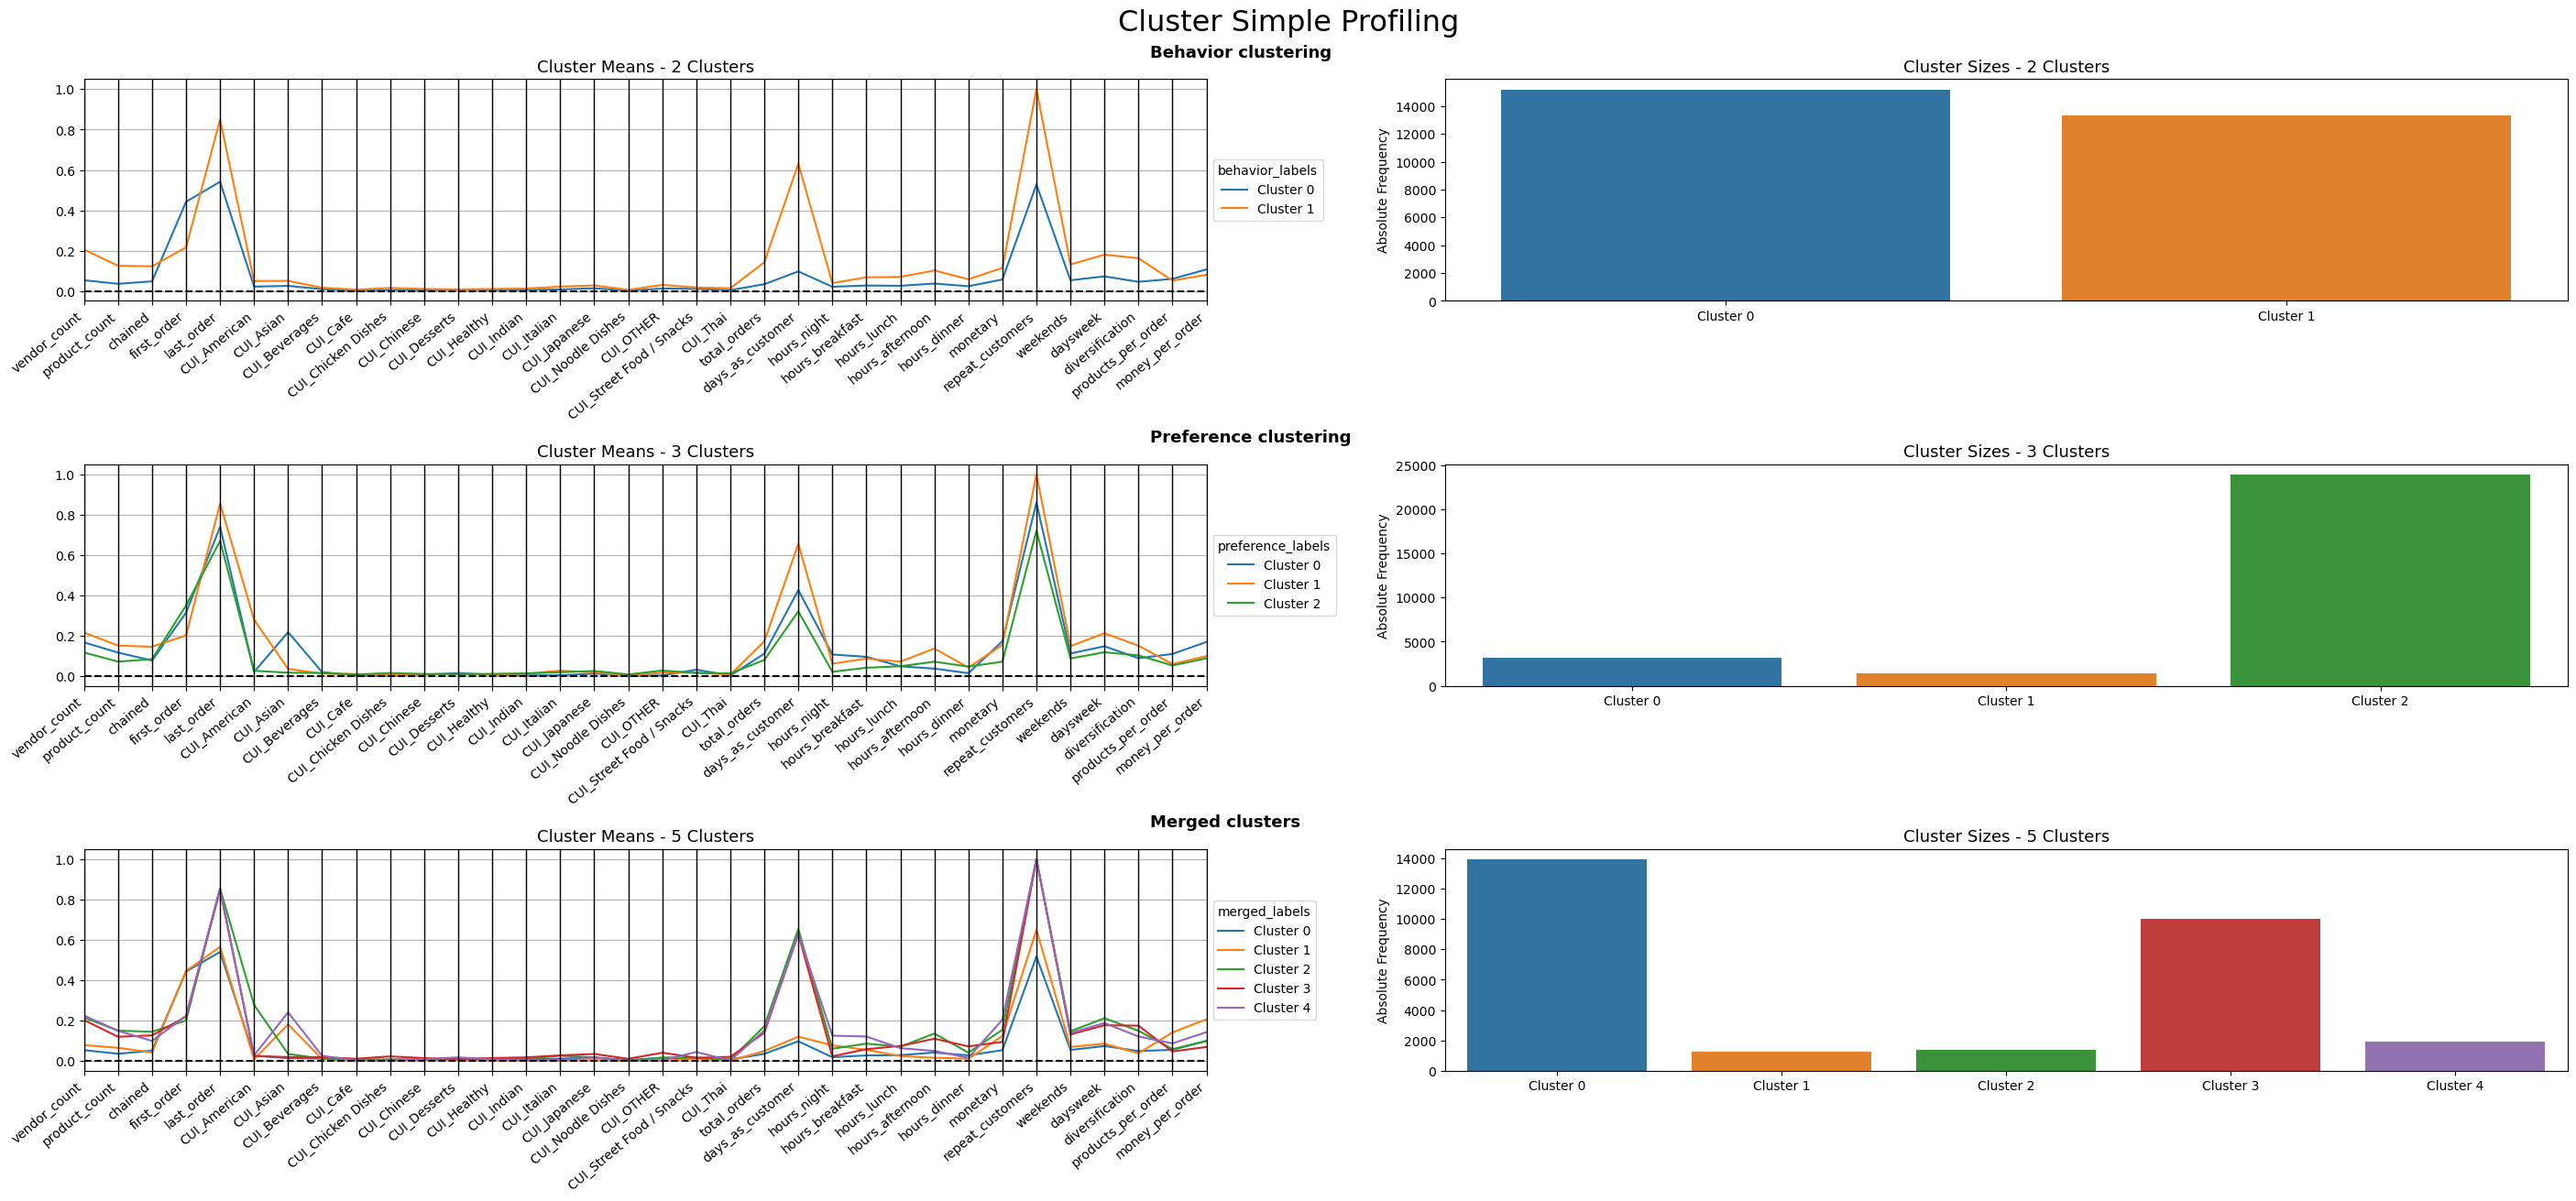

In [21]:
df = df_.copy()

# Apply the cluster profiling function
cluster_profiles(
    df=df[numeric_columns + [ 'behavior_labels','preference_labels', 'merged_labels']], 
    label_columns=['behavior_labels','preference_labels', 'merged_labels'], 
    figsize=(28, 13), 
    compare_titles=[ "Behavior clustering", "Preference clustering","Merged clusters"]
)

## 4.2. Categorical columns

In [22]:
not_used_columns

['vendor_count',
 'chained',
 'first_order',
 'total_orders',
 'hours_night',
 'hours_breakfast',
 'hours_lunch',
 'hours_afternoon',
 'hours_dinner',
 'repeat_customers',
 'weekends',
 'daysweek',
 'products_per_order',
 'money_per_order',
 'customer_region',
 'last_promo',
 'payment_method',
 'age_range',
 'customer_city']

C:\Users\marsi\AppData\Local\Temp\ipykernel_11200\4215073425.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cat = df[categorical_columns + ['merged_labels']].groupby(['merged_labels']).apply(lambda x: x.apply(lambda col: col.value_counts().to_dict(), axis=0))


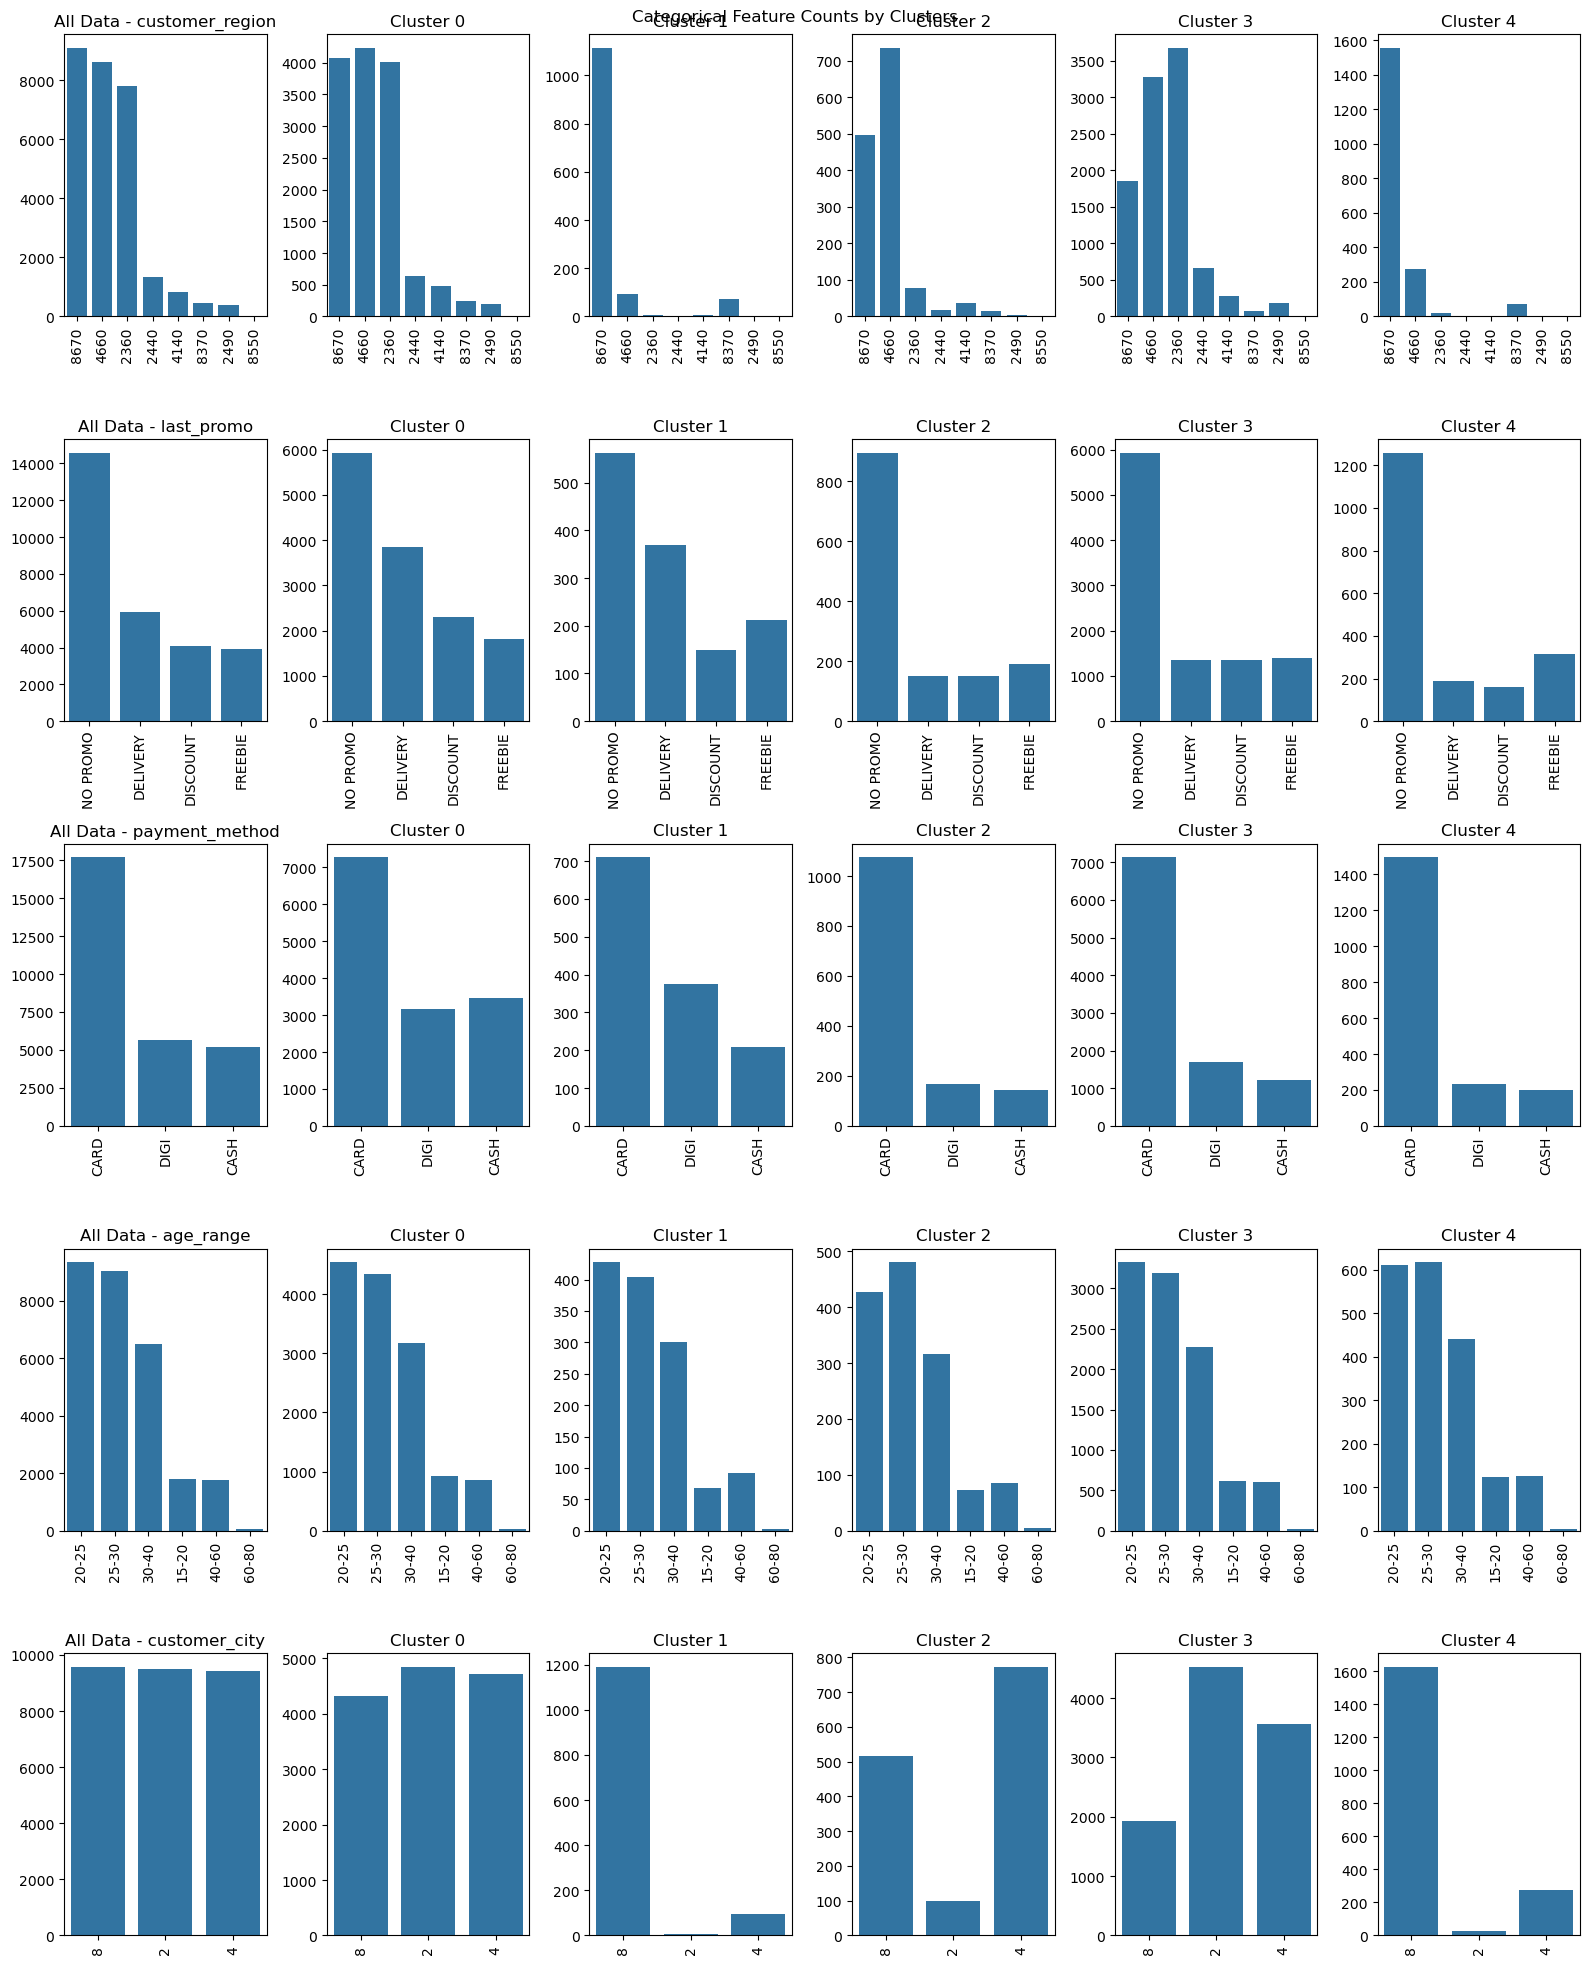

In [23]:
# Grouping by the cluster labels and summing for the categorical features
df_cat = df[categorical_columns + ['merged_labels']].groupby(['merged_labels']).apply(lambda x: x.apply(lambda col: col.value_counts().to_dict(), axis=0))

# For visualizing, let's assume you want to create count plots for each categorical feature by cluster
fig, axes = plt.subplots(len(categorical_columns), df['merged_labels'].nunique() + 1, figsize=(16, 4 * len(categorical_columns)), tight_layout=True)

for i, feature in enumerate(categorical_columns):
    for j in range(len(axes[i])):
        ax = axes[i][j]
        if j == 0:
            sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, ax=ax)
            ax.set_title(f"All Data - {feature}")
        else:
            sns.countplot(data=df[df['merged_labels'] == j - 1], x=feature, order=df[feature].value_counts().index, ax=ax)
            ax.set_title(f"Cluster {j - 1}")
        
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("")
        ax.set_ylabel("")

plt.suptitle("Categorical Feature Counts by Clusters")
plt.show()


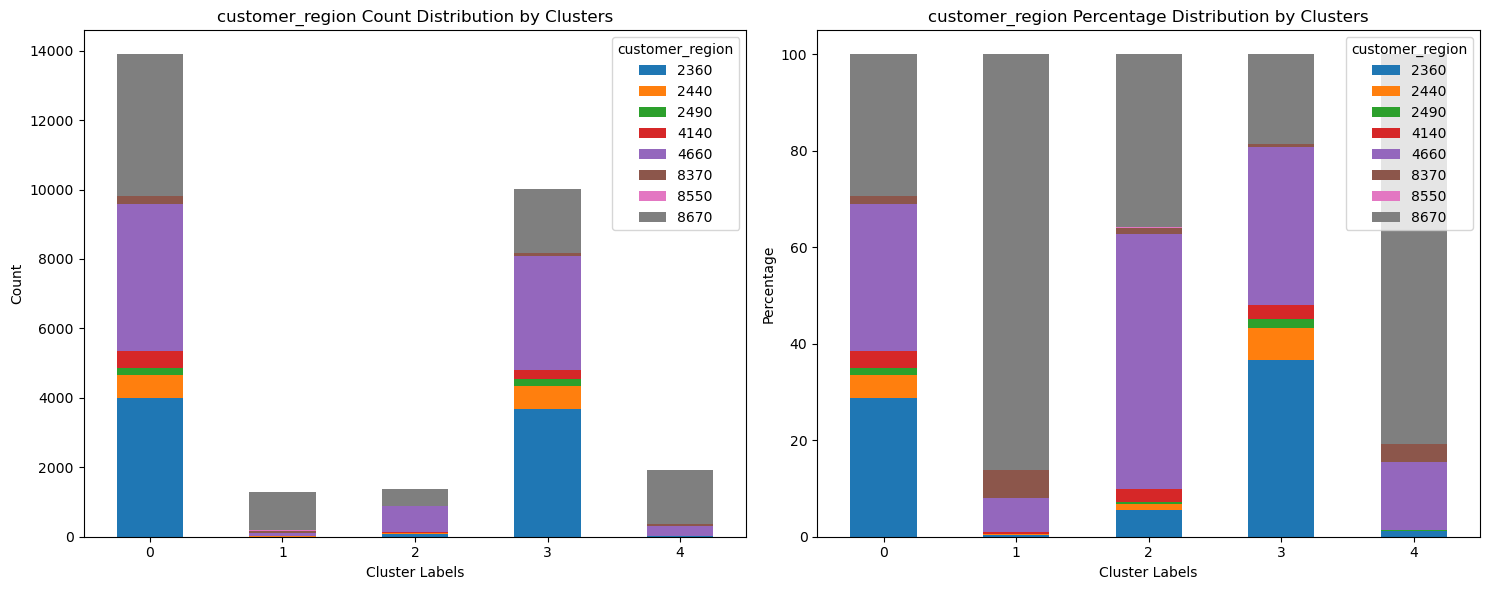

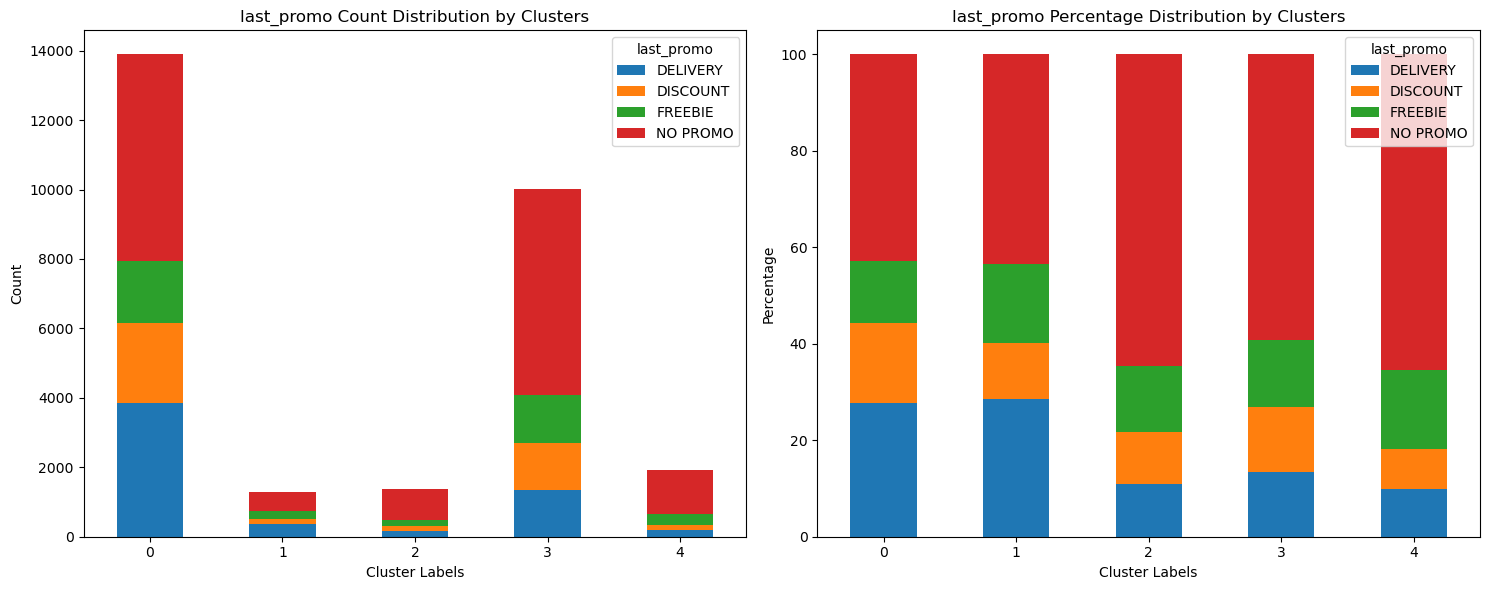

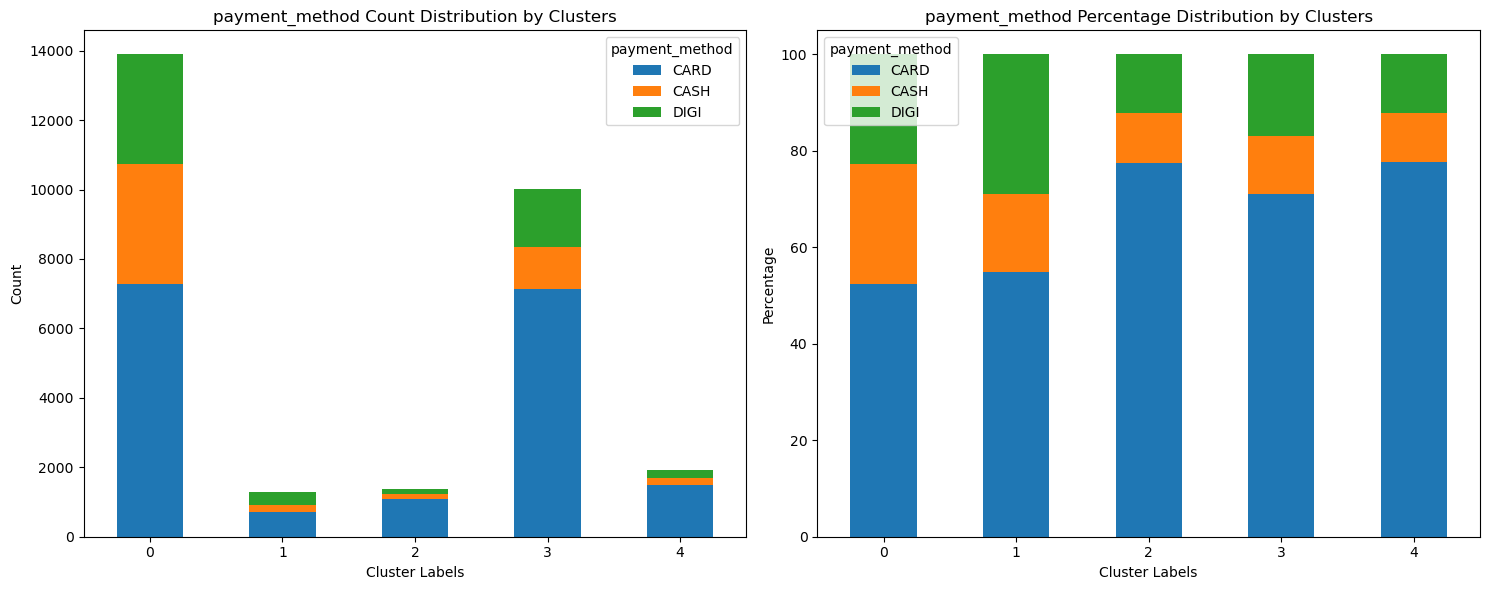

C:\Users\marsi\AppData\Local\Temp\ipykernel_11200\2259020105.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cl = df.groupby(['merged_labels', feature])[feature].size().unstack(fill_value=0)


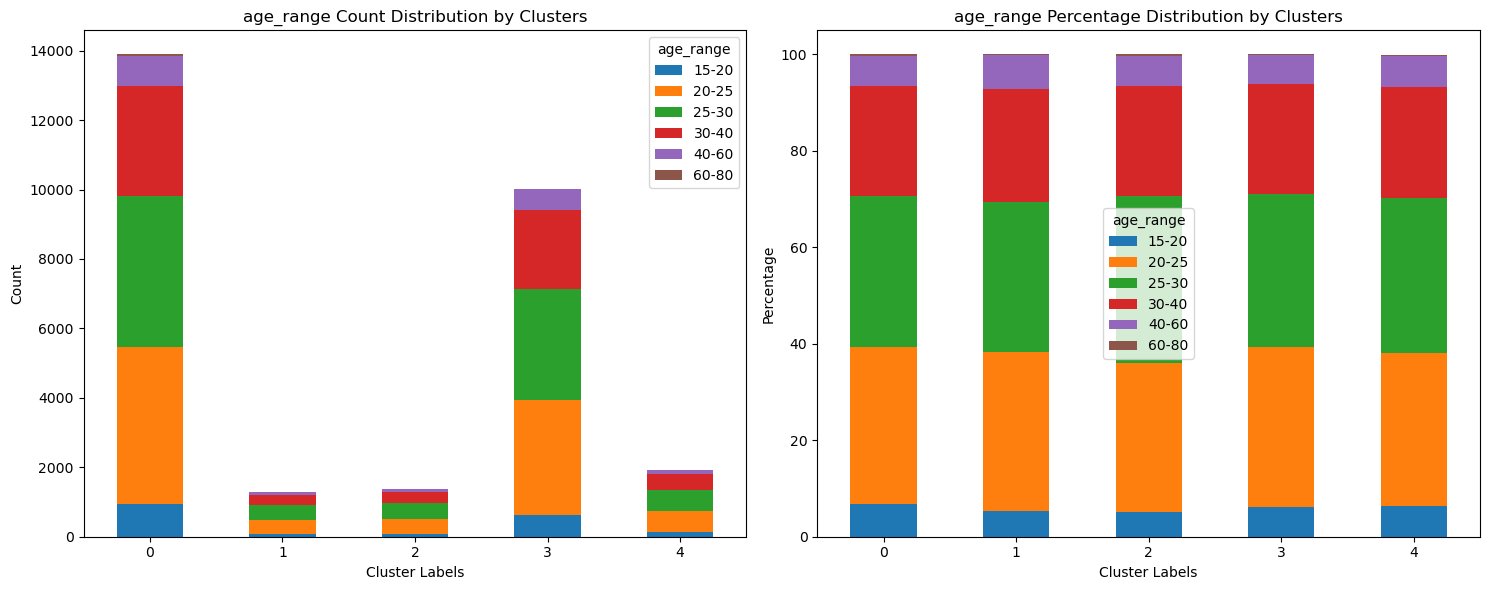

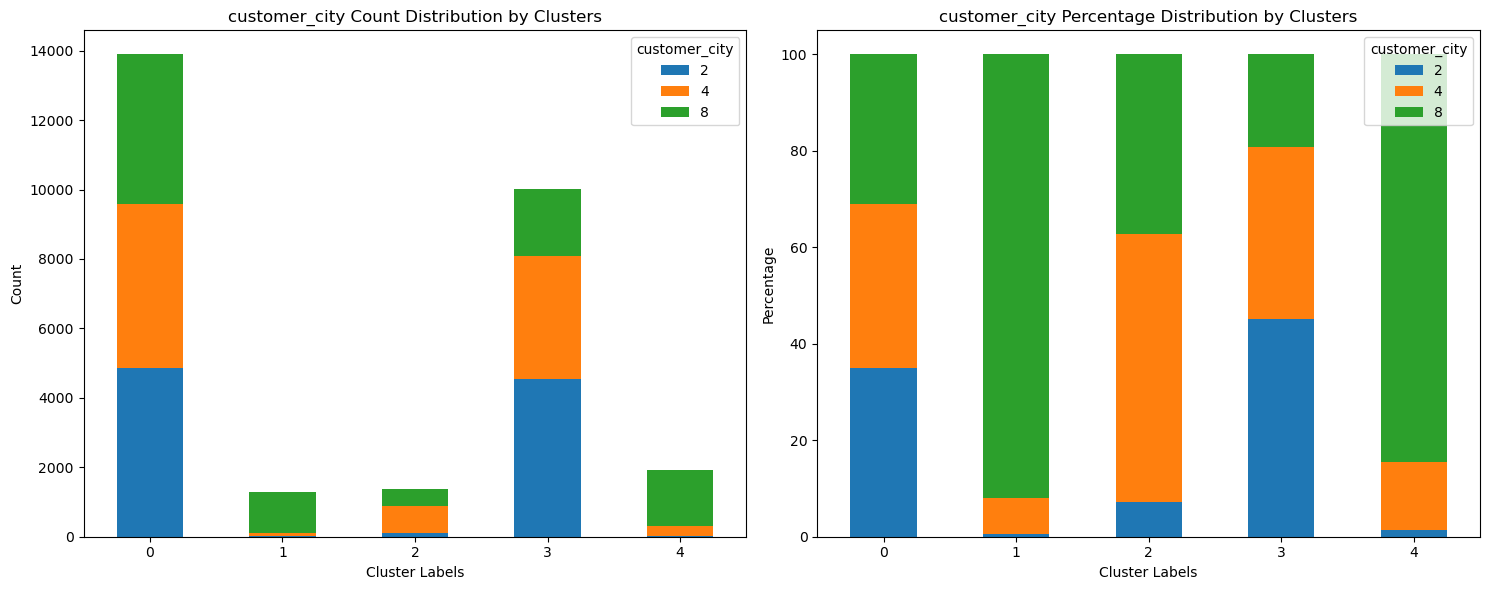

In [24]:
# Loop through each categorical feature to create both count and percentage stacked bar charts
for feature in categorical_columns:
    # Grouping by 'merged_labels' and the feature, then counting occurrences
    df_cl = df.groupby(['merged_labels', feature])[feature].size().unstack(fill_value=0)
    
    # Create the counts plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), tight_layout=True)
    
    # Count plot on the left
    df_cl.plot.bar(stacked=True, ax=axes[0], title=f'{feature} Count Distribution by Clusters')
    axes[0].set_ylabel('Count')
    axes[0].set_xlabel('Cluster Labels')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)  # Optional for better x-axis label visibility
    
    # Calculate the percentage distribution
    df_cl_pct = df_cl.copy()
    
    # Handle missing values by making sure all feature categories are considered
    # Note: We need to make sure each category in 'feature' has the right percentage calculation.
    total_counts = df['merged_labels'].value_counts().sort_index()
    
    for category in df[feature].unique():
        if category in df_cl_pct.columns:
            df_cl_pct[category] = 100 * df_cl_pct[category] / total_counts.values
    
    # Percentage plot on the right
    df_cl_pct.plot.bar(stacked=True, ax=axes[1], title=f'{feature} Percentage Distribution by Clusters')
    axes[1].set_ylabel('Percentage')
    axes[1].set_xlabel('Cluster Labels')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)  # Optional for better x-axis label visibility

    plt.show()


# 5.Assessment of clutering made
## 5.1. T-sne

In [25]:
two_dim = TSNE(random_state=42).fit_transform(df[numeric_columns])

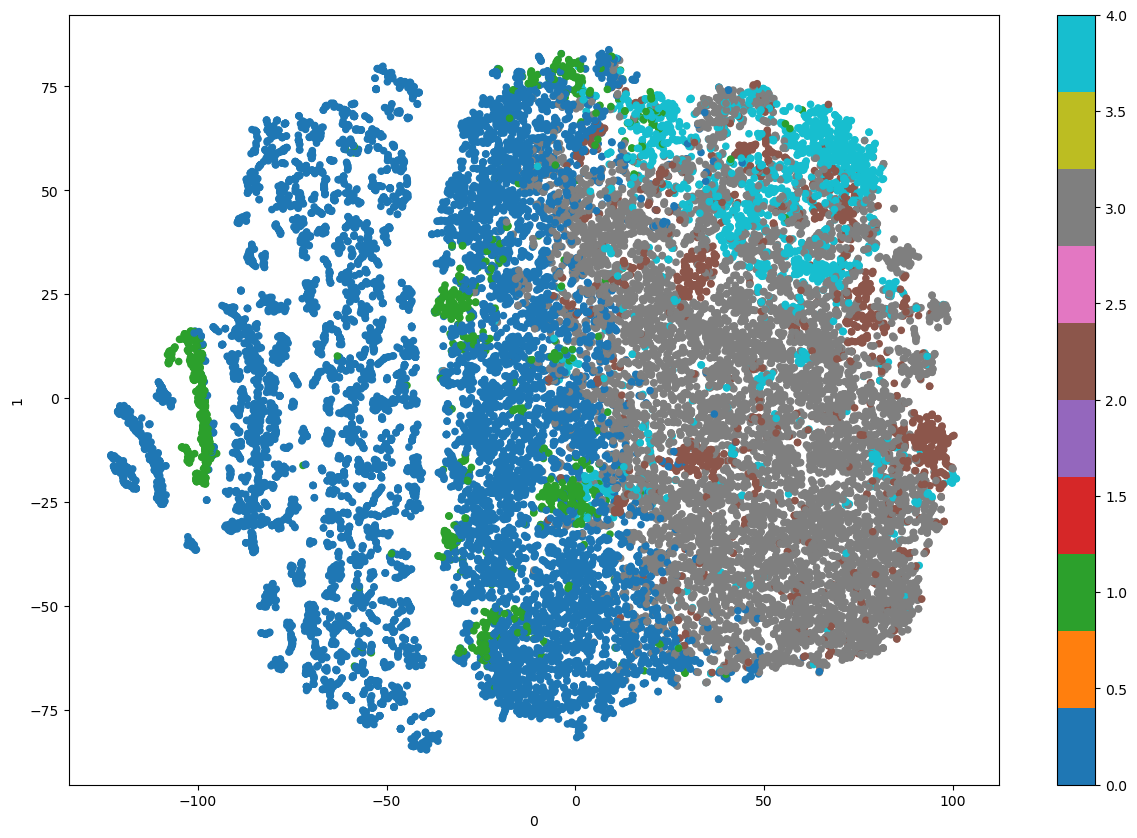

In [26]:
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


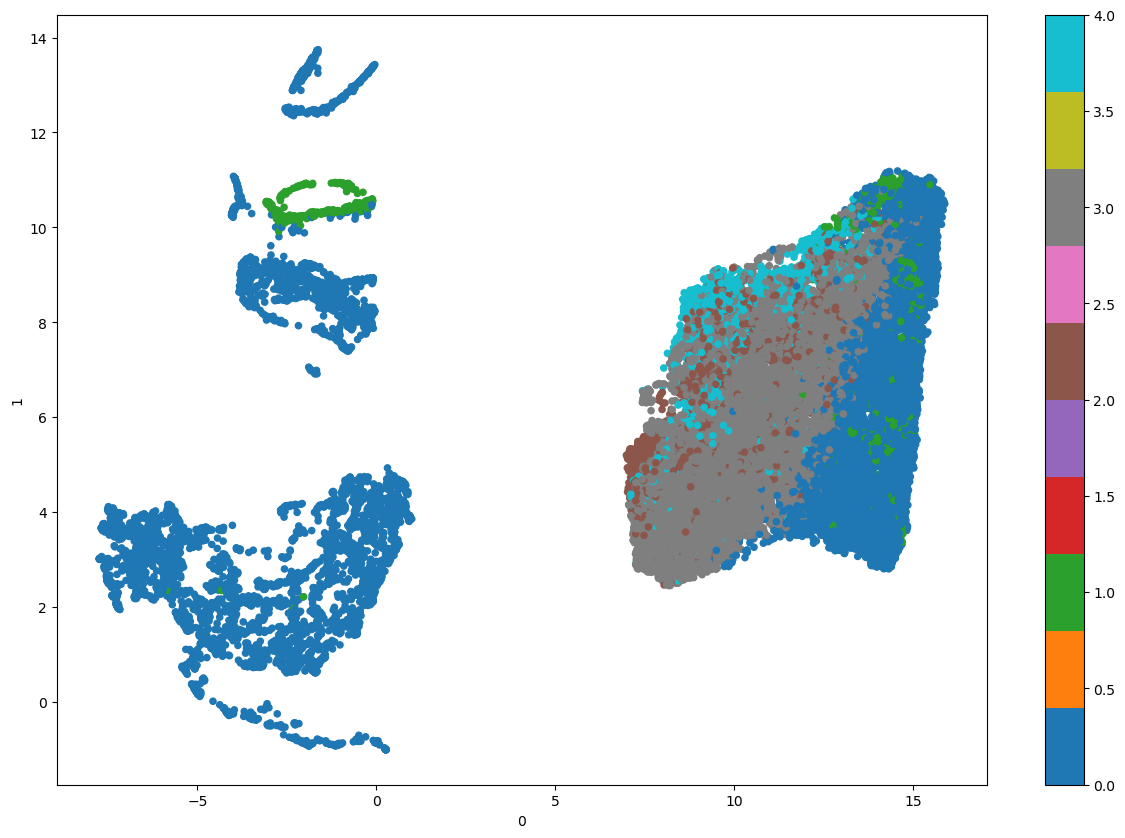

In [27]:
# Apply UMAP
umap_model = umap.UMAP(random_state=42)
two_dim_umap = umap_model.fit_transform(df[numeric_columns])

# Plot the UMAP results
pd.DataFrame(two_dim_umap).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15, 10))
plt.show()

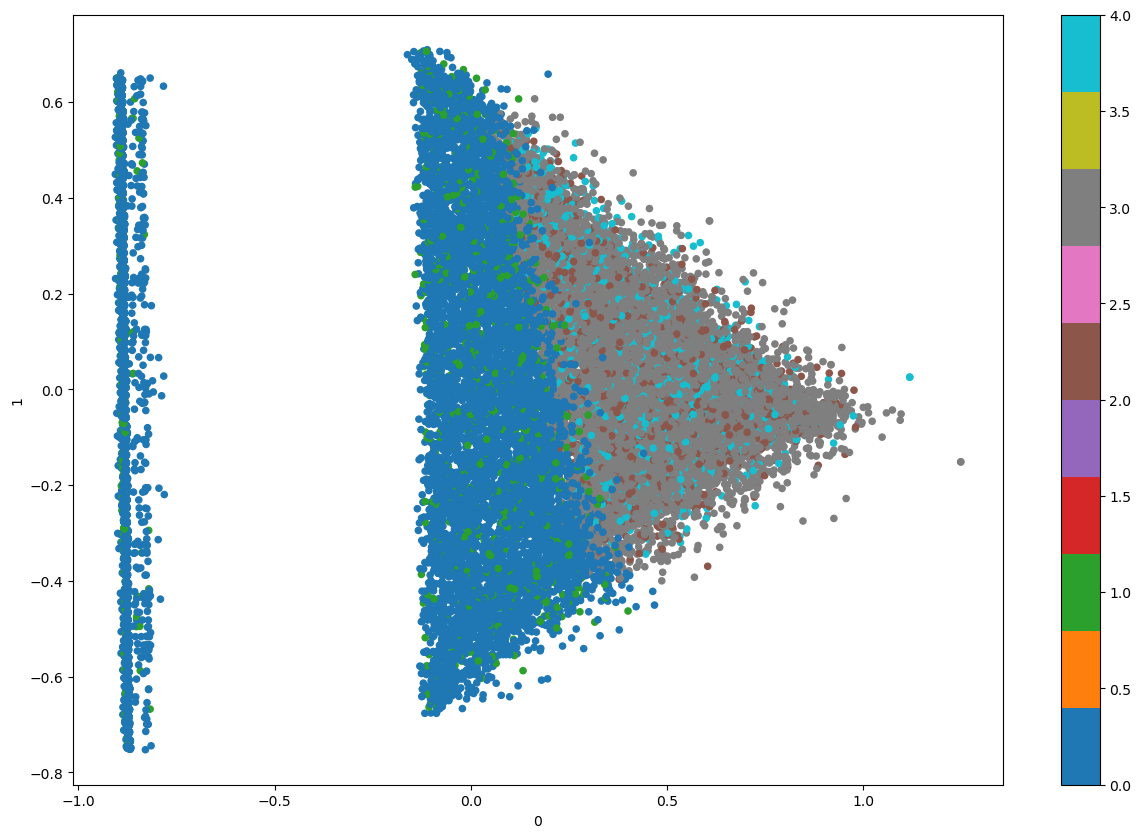

In [28]:
# Apply PCA
pca_model = PCA(n_components=2, random_state=42)
two_dim_pca = pca_model.fit_transform(df[numeric_columns])

# Plot the PCA results
pd.DataFrame(two_dim_pca).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15, 10))
plt.show()

In [29]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars
    

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [30]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[numeric_columns + ['merged_labels']], 'merged_labels').drop('merged_labels')

C:\Users\marsi\AppData\Local\Temp\ipykernel_11200\3351935109.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


vendor_count                0.314369
product_count               0.347359
chained                     0.209496
first_order                 0.175216
last_order                  0.348334
CUI_American                0.455478
CUI_Asian                   0.642938
CUI_Beverages               0.006897
CUI_Cafe                    0.006577
CUI_Chicken Dishes          0.025451
CUI_Chinese                 0.009674
CUI_Desserts                0.002286
CUI_Healthy                 0.005816
CUI_Indian                  0.013140
CUI_Italian                 0.033959
CUI_Japanese                0.019082
CUI_Noodle Dishes           0.011421
CUI_OTHER                   0.043094
CUI_Street Food / Snacks    0.015905
CUI_Thai                    0.016510
total_orders                0.377273
days_as_customer            0.746343
hours_night                 0.147007
hours_breakfast             0.097710
hours_lunch                 0.100699
hours_afternoon             0.137176
hours_dinner                0.057981
m

In [31]:
# Preparing the data
X = df[numeric_columns]
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 91.83% of the customers correctly


In [32]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

days_as_customer            0.580822
CUI_Asian                   0.293891
CUI_American                0.125287
vendor_count                0.000000
hours_dinner                0.000000
total_orders                0.000000
hours_night                 0.000000
hours_breakfast             0.000000
hours_lunch                 0.000000
hours_afternoon             0.000000
monetary                    0.000000
CUI_Street Food / Snacks    0.000000
repeat_customers            0.000000
weekends                    0.000000
daysweek                    0.000000
diversification             0.000000
products_per_order          0.000000
CUI_Thai                    0.000000
CUI_OTHER                   0.000000
product_count               0.000000
CUI_Noodle Dishes           0.000000
CUI_Japanese                0.000000
CUI_Italian                 0.000000
CUI_Indian                  0.000000
CUI_Healthy                 0.000000
CUI_Desserts                0.000000
CUI_Chinese                 0.000000
C